In [1]:
#%pip install bertviz
#%pip install ipywidgets
#%pip install lime

In [1]:
import pandas as pd
import numpy as np
import pickle
import os
from bertviz import model_view, head_view
from transformers import AutoTokenizer, utils, AutoModelForSeq2SeqLM
utils.logging.set_verbosity_error()  # Suppress standard warnings

os.environ["CUDA_VISIBLE_DEVICES"] = "3"


ANALYSIS_POSTFIX = "mined_sudden_2024-08-16"

In [2]:
with open(f"../ensemble_learning/reports/results/{ANALYSIS_POSTFIX}/cv_results.pickle", "rb") as handle:
    cv_predictions = pickle.load(handle)

with open(f"../ensemble_learning/reports/results/{ANALYSIS_POSTFIX}/test_results.pickle", "rb") as handle:
    test_predictions = pickle.load(handle)

with open(f"../ensemble_learning/reports/results/{ANALYSIS_POSTFIX}/s2_model_results.pickle", "rb") as handle:
    s2_predictions = pickle.load(handle)


In [3]:
#model_name = "/home/RDC/zinovyee.hub/H:/zinovyee.hub/IRTG/MLSC/MLSC_DD/ensemble_learning/models/5_epoch_set"  # Find popular HuggingFace models here: https://huggingface.co/models
model_name = "Salesforce/codet5-base-multi-sum"
input_text = "sum(d * 10 ** i for i, d in enumerate(x[::-1]))"  
model = AutoModelForSeq2SeqLM.from_pretrained(model_name, output_attentions=True)  # Configure model to return attention values
tokenizer = AutoTokenizer.from_pretrained(model_name)

# PREPARE AN EXAMPLE
input_ids = tokenizer(input_text, return_tensors="pt").input_ids
generated_ids = model.generate(input_ids, max_length=20)
output_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print(output_text)

encoder_input_ids = tokenizer(input_text, return_tensors="pt", add_special_tokens=True).input_ids
with tokenizer.as_target_tokenizer():
    decoder_input_ids = tokenizer(output_text, return_tensors="pt", add_special_tokens=True).input_ids
outputs = model(input_ids=encoder_input_ids, decoder_input_ids=decoder_input_ids)

encoder_text = tokenizer.convert_ids_to_tokens(encoder_input_ids[0])
decoder_text = tokenizer.convert_ids_to_tokens(decoder_input_ids[0])
print(decoder_text)

/home/RDC/zinovyee.hub/.conda/envs/ensemble/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/RDC/zinovyee.hub/.conda/envs/ensemble/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sum of the values in the last 10 - bit interval.


/home/RDC/zinovyee.hub/.conda/envs/ensemble/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3935: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


['<s>', 'Sum', 'Ġof', 'Ġthe', 'Ġvalues', 'Ġin', 'Ġthe', 'Ġlast', 'Ġ10', 'Ġ-', 'Ġbit', 'Ġinterval', '.', '</s>']


In [5]:
model_view(
    encoder_attention=outputs.encoder_attentions,
    decoder_attention=outputs.decoder_attentions,
    cross_attention=outputs.cross_attentions,
    encoder_tokens= encoder_text,
    decoder_tokens = decoder_text,
    display_mode="light"
)

<IPython.core.display.Javascript object>

In [25]:
from lime import lime_text

from sklearn.feature_extraction.text import TfidfVectorizer
from utils.int_training import vectorize_input_df, train_classifier, classifier_inference


from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=['non-acceptable', 'acceptable'])

In [26]:
vectorizer = TfidfVectorizer()

In [27]:
res = vectorize_input_df(df=cv_predictions, vectorizer=vectorizer, fit=True, acc_rouge=0.15)
X, y, vectorizer = res["X"], res["y"], res["vectorizer"]

classifier = train_classifier(X, y)

Learning rate set to 0.008283
0:	learn: 0.6862904	total: 7.05ms	remaining: 7.04s
1:	learn: 0.6790585	total: 8.34ms	remaining: 4.16s
2:	learn: 0.6728824	total: 9.7ms	remaining: 3.22s
3:	learn: 0.6663624	total: 11.8ms	remaining: 2.94s
4:	learn: 0.6609764	total: 18.5ms	remaining: 3.68s
5:	learn: 0.6545841	total: 20.1ms	remaining: 3.33s
6:	learn: 0.6489244	total: 23.8ms	remaining: 3.37s
7:	learn: 0.6415103	total: 43.9ms	remaining: 5.45s
8:	learn: 0.6343040	total: 45.3ms	remaining: 4.99s
9:	learn: 0.6267972	total: 46.5ms	remaining: 4.6s
10:	learn: 0.6212538	total: 47.5ms	remaining: 4.27s
11:	learn: 0.6150877	total: 48.6ms	remaining: 4s
12:	learn: 0.6092655	total: 49.6ms	remaining: 3.76s
13:	learn: 0.6037320	total: 50.6ms	remaining: 3.56s
14:	learn: 0.5975861	total: 52ms	remaining: 3.41s
15:	learn: 0.5927285	total: 53ms	remaining: 3.26s
16:	learn: 0.5864868	total: 54ms	remaining: 3.12s
17:	learn: 0.5821839	total: 55.3ms	remaining: 3.02s
18:	learn: 0.5769073	total: 56.6ms	remaining: 2.92s
19:

In [28]:
import matplotlib.pyplot as plt

In [29]:
features = list(vectorizer.get_feature_names_out())
features = list(cv_predictions.model_set.unique()) + features

Text(0.5, 1.0, 'Feature Importance')

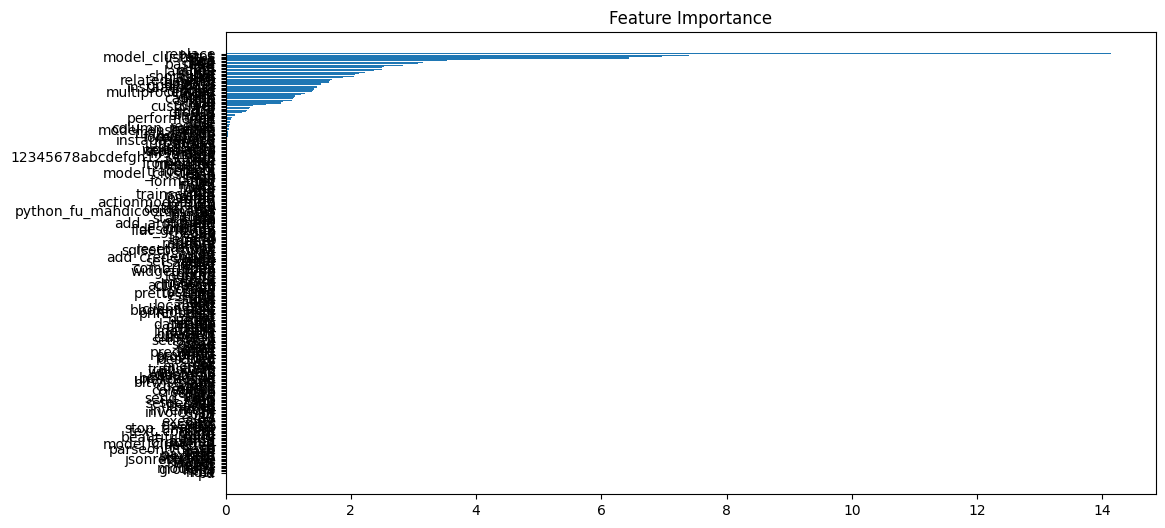

In [30]:

feature_importance = classifier.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features)[sorted_idx])
plt.title('Feature Importance')


In [31]:
def vectorize_obs(input_texts, cv_predictions):

    global vectorizer

    if isinstance(input_texts, str):
        input_texts = [input_texts]

    dummy_df = cv_predictions.groupby("model_set").head(1).reset_index(drop=True)[["input_sequence", "model_set", "catboost_perf_hat"]]
    for i_text in input_texts:
        row_copy = dummy_df.iloc[[-1]].copy()
        row_copy["input_sequence"] = i_text
        row_copy["model_set"] = 0

        dummy_df = pd.concat([dummy_df, row_copy], axis=0)

    vectorized = vectorize_input_df(df=dummy_df, vectorizer=vectorizer, fit=False, acc_rouge=0.15)["X"]
    print(len(input_texts))
    X = vectorized[-len(input_texts):]
    return X 


In [32]:
def lime_classifier(txt):
  
  global classfier 
  global cv_predictions 
  txt = vectorize_obs(input_texts=txt, cv_predictions=cv_predictions)
  probs = classifier.predict_proba(txt)
  return probs

In [52]:
expl = explainer.explain_instance("model_1 sorted(Thing.objects.all(), key=lambda t: t.name)", lime_classifier,  num_samples=50)

50


In [ ]:
cv_predictions[cv_predictions.catboost_perf_hat>0.15]

In [54]:
expl.show_in_notebook(text=False)